In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

from tyssue_taylor.adjusters.adjust_annular import (set_init_point, prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.notebook_tools.ntbk_tools import (print_tensions, rendering_results,
                                                     rendering_convergence_results, create_organo)

In [2]:
nb_cells = 10
r_in = 110
r_out = 150

# Symetric case

In [6]:
seed = 1553
sym_organo = create_organo(seed, 10, 110, 150)

Reseting datasets values with new specs


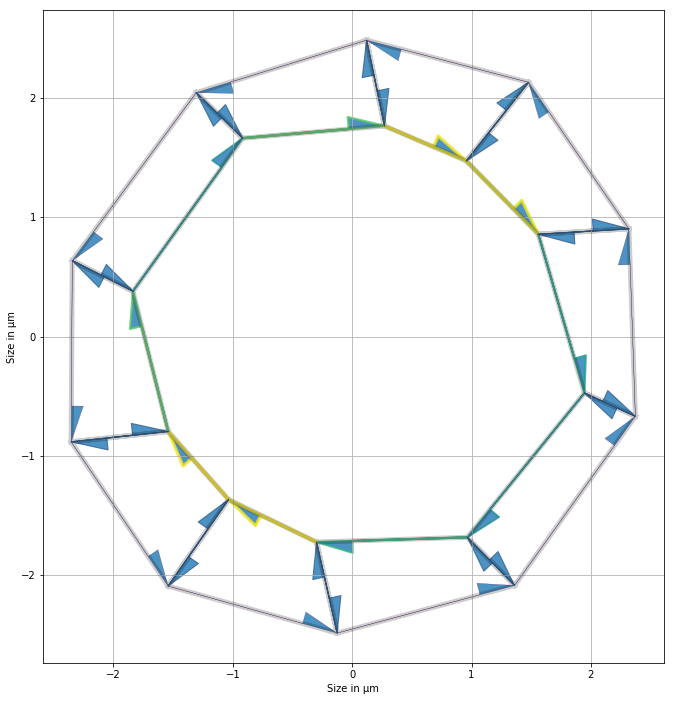

In [8]:
print_tensions(sym_organo, sym_organo)

In [20]:
sym_organo.settings

{'geometry': 'planar',
 'R_in': 1.8280864428413166,
 'R_out': 2.492845149329068,
 'R_vit': None,
 'lumen_volume': 19.608309330918885,
 'lumen_elasticity': 0.1,
 'lumen_prefered_vol': 19.643195596172177}

             x         y
vert                    
0     1.945834 -0.472759
1     0.964937 -1.681778
2    -0.298644 -1.721525
3    -1.035858 -1.365147
4    -1.541059 -0.795235
5    -1.836542  0.379746
6    -0.917519  1.661811
7     0.270874  1.764642
8     0.956599  1.471441
9     1.559566  0.856988
10    2.372930 -0.668422
11    1.360486 -2.085664
12   -0.125895 -2.484822
13   -1.542269 -2.090634
14   -2.354400 -0.882160
15   -2.345490  0.636233
16   -1.306026  2.044000
17    0.120727  2.483423
18    1.478055  2.130458
19    2.318725  0.902711
      srce  trgt    length
edge                      
0        0     1  1.556883
1        1     2  1.264206
2        2     3  0.818834
3        3     4  0.761596
4        4     5  1.211565
5        5     6  1.577433
6        6     7  1.192834
7        7     8  0.745779
8        8     9  0.860884
9        9     0  1.384713
10      11    10  1.741728
11      12    11  1.539044
12      13    12  1.470204
13      14    13  1.456010
14      15    14  

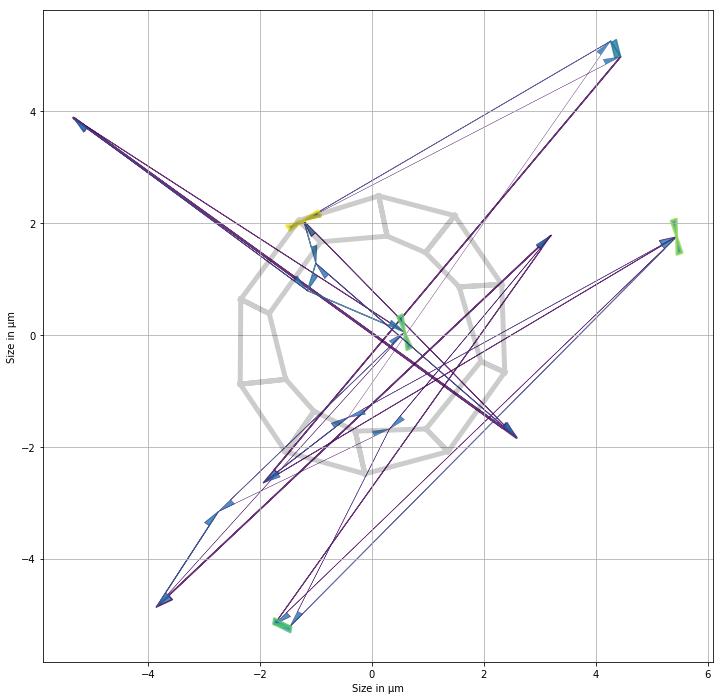

In [23]:
fi_sym_organo = sym_organo.copy()
coefs = _coef_matrix(fi_sym_organo, 'areas')
constant = _right_side(fi_sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(sym_organo, 'areas')
# RES_INFERENCE = _qp_model(sym_organo, 'simple', True, 0)
res_inference = infer_forces(fi_sym_organo, method='LINALG',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(sym_organo.vert_df.loc[:, ('x', 'y')])
print(sym_organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
fi_sym_organo.edge_df.line_tension = prepare_tensions(fi_sym_organo, res_inference['tensions'])
fi_sym_organo.face_df.prefered_area = sym_organo.face_df.area + res_inference['areas'][:-1]
fi_sym_organo.settings['lumen_prefered_vol'] = sym_organo.settings['lumen_prefered_vol'] + res_inference['areas'][-1]
Solver.find_energy_min(fi_sym_organo, geom, model)
print_tensions(fi_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, fi_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                fi_sym_organo.edge_df.line_tension[:3*nb_cells]))))

             x         y
vert                    
0     1.945834 -0.472759
1     0.964937 -1.681778
2    -0.298644 -1.721525
3    -1.035858 -1.365147
4    -1.541059 -0.795235
5    -1.836542  0.379746
6    -0.917519  1.661811
7     0.270874  1.764642
8     0.956599  1.471441
9     1.559566  0.856988
10    2.372930 -0.668422
11    1.360486 -2.085664
12   -0.125895 -2.484822
13   -1.542269 -2.090634
14   -2.354400 -0.882160
15   -2.345490  0.636233
16   -1.306026  2.044000
17    0.120727  2.483423
18    1.478055  2.130458
19    2.318725  0.902711
      srce  trgt    length
edge                      
0        0     1  1.556883
1        1     2  1.264206
2        2     3  0.818834
3        3     4  0.761596
4        4     5  1.211565
5        5     6  1.577433
6        6     7  1.192834
7        7     8  0.745779
8        8     9  0.860884
9        9     0  1.384713
10      11    10  1.741728
11      12    11  1.539044
12      13    12  1.470204
13      14    13  1.456010
14      15    14  

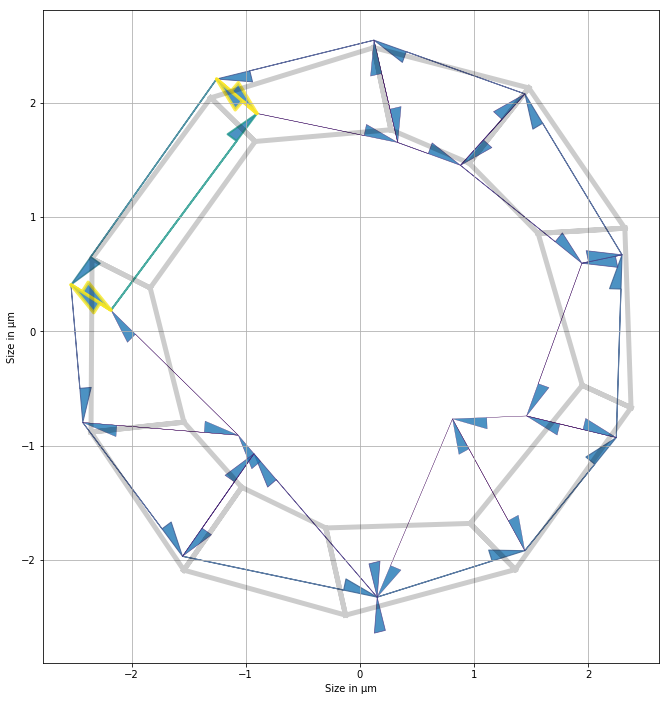

In [26]:
fi_sym_organo = sym_organo.copy()
coefs = _coef_matrix(fi_sym_organo, 'areas')
constant = _right_side(fi_sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(sym_organo, 'areas')
# RES_INFERENCE = _qp_model(sym_organo, 'simple', True, 0)
res_inference = infer_forces(fi_sym_organo, method='NNLS',
                             sup_param='areas', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions'],
                         res_inference['areas']))
print(sym_organo.vert_df.loc[:, ('x', 'y')])
print(sym_organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
fi_sym_organo.edge_df.line_tension = prepare_tensions(fi_sym_organo, res_inference['tensions'])
fi_sym_organo.face_df.prefered_area = sym_organo.face_df.area + res_inference['areas'][:-1]
fi_sym_organo.settings['lumen_prefered_vol'] = sym_organo.settings['lumen_prefered_vol'] + res_inference['areas'][-1]
Solver.find_energy_min(fi_sym_organo, geom, model)
print_tensions(fi_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, fi_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                fi_sym_organo.edge_df.line_tension[:3*nb_cells]))))

             x         y
vert                    
0     1.945834 -0.472759
1     0.964937 -1.681778
2    -0.298644 -1.721525
3    -1.035858 -1.365147
4    -1.541059 -0.795235
5    -1.836542  0.379746
6    -0.917519  1.661811
7     0.270874  1.764642
8     0.956599  1.471441
9     1.559566  0.856988
10    2.372930 -0.668422
11    1.360486 -2.085664
12   -0.125895 -2.484822
13   -1.542269 -2.090634
14   -2.354400 -0.882160
15   -2.345490  0.636233
16   -1.306026  2.044000
17    0.120727  2.483423
18    1.478055  2.130458
19    2.318725  0.902711
      srce  trgt    length
edge                      
0        0     1  1.556883
1        1     2  1.264206
2        2     3  0.818834
3        3     4  0.761596
4        4     5  1.211565
5        5     6  1.577433
6        6     7  1.192834
7        7     8  0.745779
8        8     9  0.860884
9        9     0  1.384713
10      11    10  1.741728
11      12    11  1.539044
12      13    12  1.470204
13      14    13  1.456010
14      15    14  

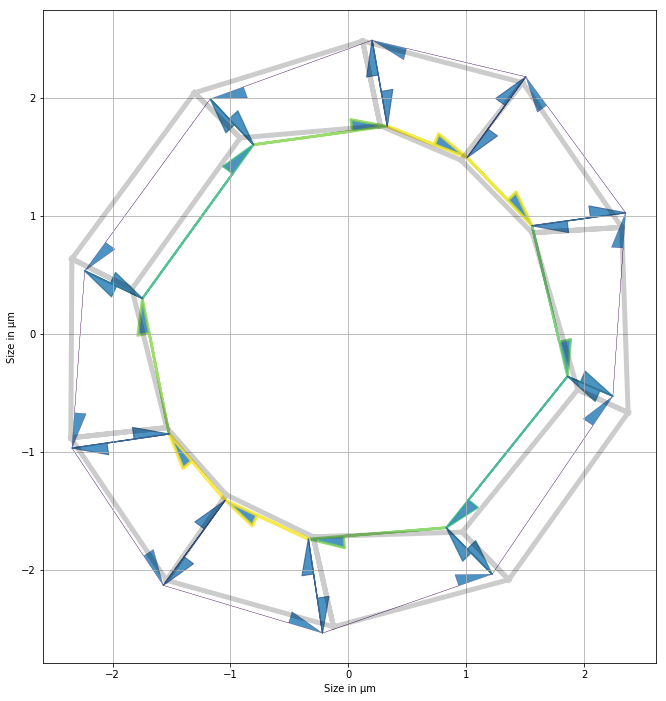

In [29]:
fi_sym_organo = sym_organo.copy()
coefs = _coef_matrix(fi_sym_organo, '')
constant = _right_side(fi_sym_organo, coefs)
# DF_CONSTANT.to_csv('b_'+str(NF)+'cells.csv', index=False)
# RES_INFERENCE = _linear_model(sym_organo, 'areas')
# RES_INFERENCE = _qp_model(sym_organo, 'simple', True, 0)
res_inference = infer_forces(fi_sym_organo, method='NNLS',
                             sup_param='', no_scale=False)
to_vect_res = np.hstack((res_inference['tensions']))
print(sym_organo.vert_df.loc[:, ('x', 'y')])
print(sym_organo.edge_df.loc[:, ('srce', 'trgt', 'length')])
print('A :\n', coefs)
print('b :', constant)
print('Ax*-b: ', np.dot(coefs, to_vect_res)-constant)
print('||Ax*-b||: ', np.linalg.norm(np.dot(coefs, to_vect_res) -
                                    constant))
print(res_inference)
fi_sym_organo.edge_df.line_tension = prepare_tensions(fi_sym_organo, res_inference['tensions'])
Solver.find_energy_min(fi_sym_organo, geom, model)
print_tensions(fi_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, fi_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                fi_sym_organo.edge_df.line_tension[:3*nb_cells]))))

## Force inference

Solving time: 9.855619
Distance from th organo to exp organo : 11.685962499279892
Distance from th tensions to exp tensions : 7.355946740645371


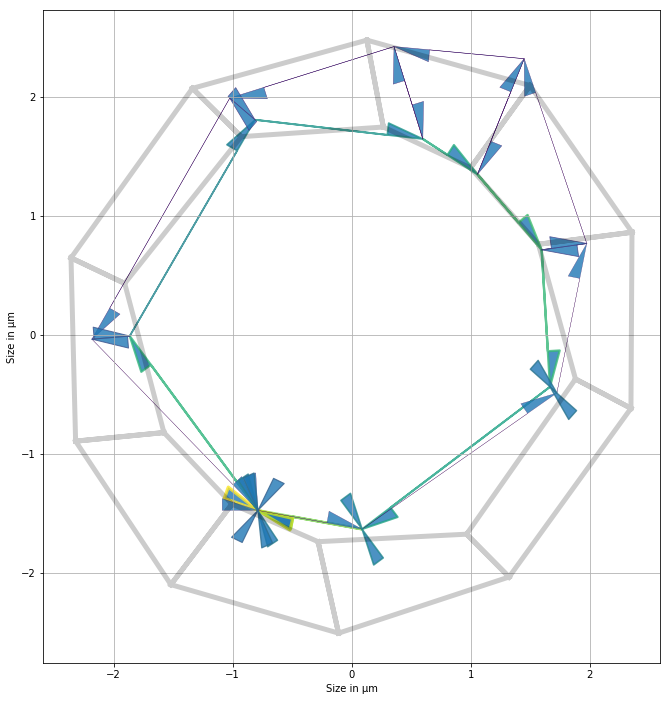

In [9]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='')
start = time.clock()
tensions_sym_organo = sym_organo.copy()
tensions_sym_organo.edge_df.line_tension = prepare_tensions(tensions_sym_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(tensions_sym_organo, False))
Solver.find_energy_min(tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(tensions_sym_organo, False))
print_tensions(tensions_sym_organo, sym_organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

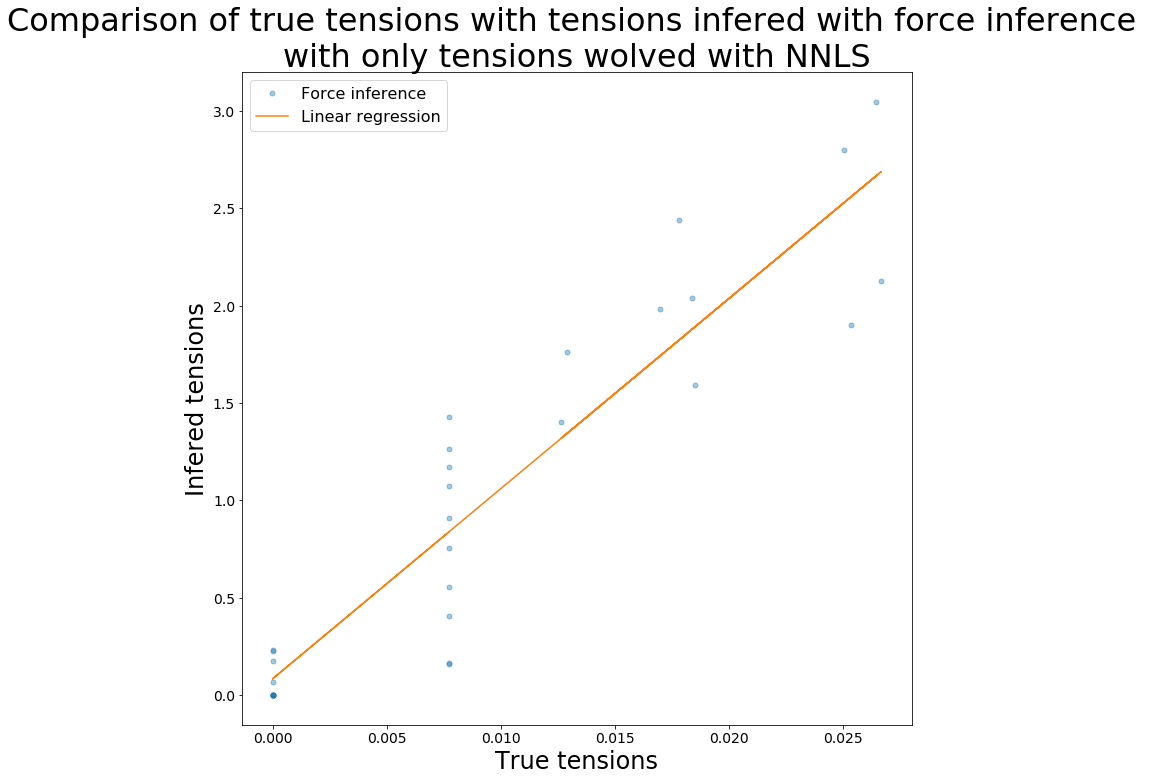

R value : 0.9256842737056845 
Standard error : 0.30357489695321166


In [10]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1   78.64      10      0.00000     1.42126
   2   86.62      15      0.00000     1.42126
   3   91.29      20      0.01000     1.05026
   4   101.35      35      0.01100     0.58682
Brut force search summary
              solving time: 101.35229015350342
              nb iter: 4
              nfev: 35
              x_ub: 0.011
              ub: 0.5868152762942953
Optimization terminated successfully.
         Current function value: 0.586808
         Iterations: 4
         Function evaluations: 8
Solving time: 104.951667
Distance from th sym_organo to exp sym_organo : 0.5868077989441718
Distance from th tensions to exp tensions : 0.022860899189818543


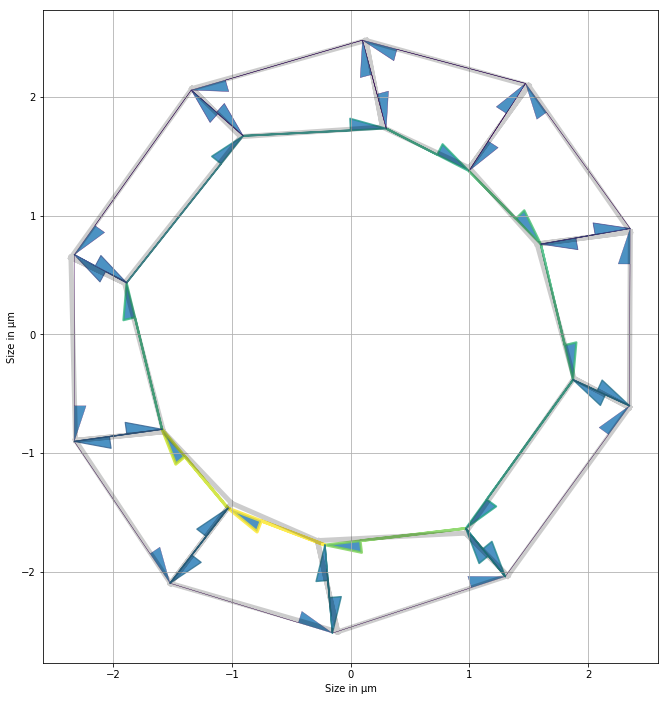

In [11]:
initial_guess = infer_forces(sym_organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_tensions_sym_organo = sym_organo.copy()
opt_scale = adjust_scale(sym_organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_tensions_sym_organo.edge_df.line_tension = prepare_tensions(rescaled_tensions_sym_organo,
                                                                 opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, rescaled_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

In [12]:
dist_init_point = np.sum(np.linalg.norm(_distance(tensions_sym_organo, sym_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(sym_organo, rescaled_tensions_sym_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                             tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th sym_organo to exp sym_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 11.685962499279892
Distance from th sym_organo to exp sym_organo at optima: 0.5868077989441718
Distance from th tensions to exp tensions at initial point : 7.355946740645371
Distance from th tensions to exp tensions at initial point : 0.022860899189818543


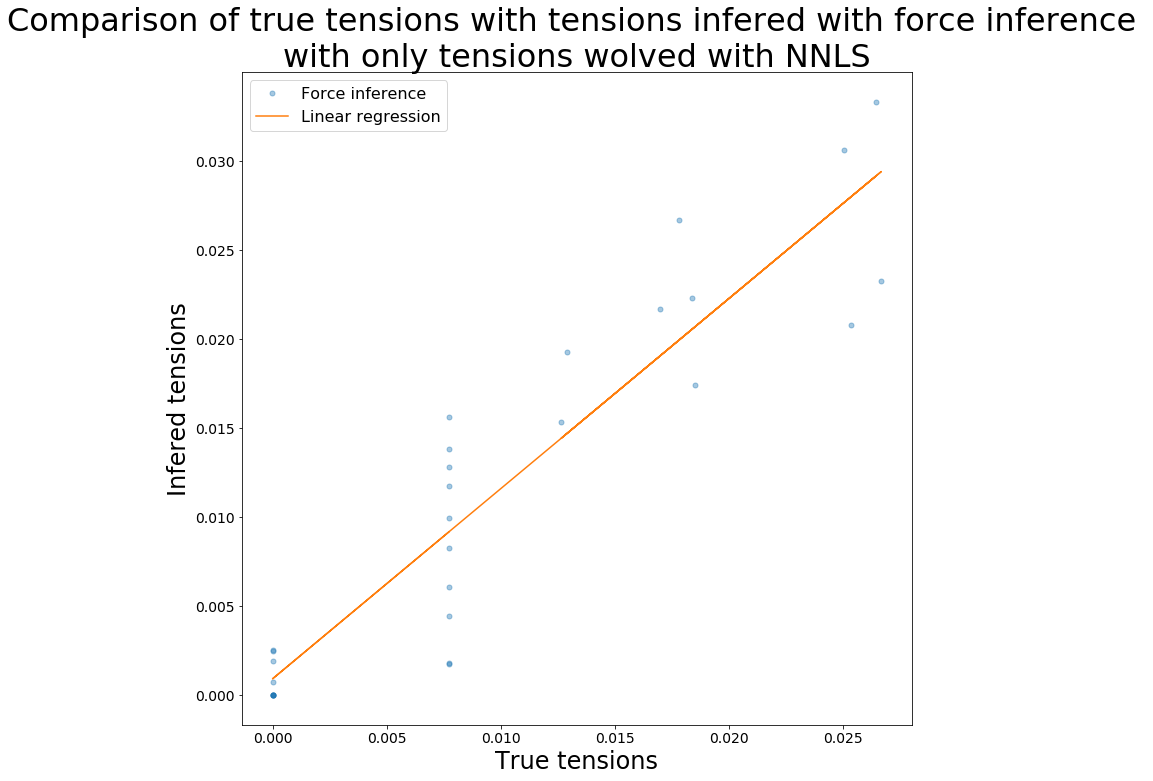

R value : 0.9256842737056844 
Standard error : 0.0033184530923197953


In [13]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  rescaled_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

## Distance minimization

`ftol` termination condition is satisfied.
Function evaluations 1531, initial cost 2.9717e-05, final cost 4.3989e-08, first-order optimality 2.17e-06.
Solving time: 299.015583
Distance from th sym_organo to exp sym_organo : 0.0
Distance from th tensions to exp tensions : 0.0034810109632530113


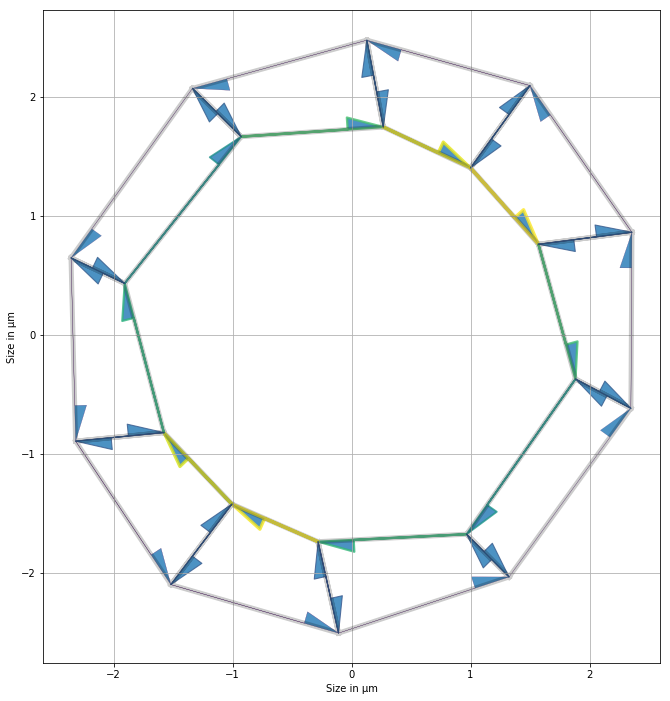

In [14]:
iprint_file = "../../assets/dist_at_each_f_ev/synth_only_tensions.txt"
res_sym_tensions = adjust_tensions(sym_organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_tensions_sym_organo = sym_organo.copy()
opt_tensions_sym_organo.edge_df.line_tension = prepare_tensions(opt_tensions_sym_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_tensions_sym_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_tensions_sym_organo, sym_organo)
print('Distance from th sym_organo to exp sym_organo : ' +
      str(np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))))

In [15]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_tensions_sym_organo, sym_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(sym_organo, opt_tensions_sym_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(sym_organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_tensions_sym_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th sym_organo to exp sym_organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.5868077989441718
Distance from th sym_organo to exp sym_organo at optima: 0.0
Distance from th tensions to exp tensions at initial point : 0.022860899189818543
Distance from th tensions to exp tensions at initial point : 0.0034810109632530113


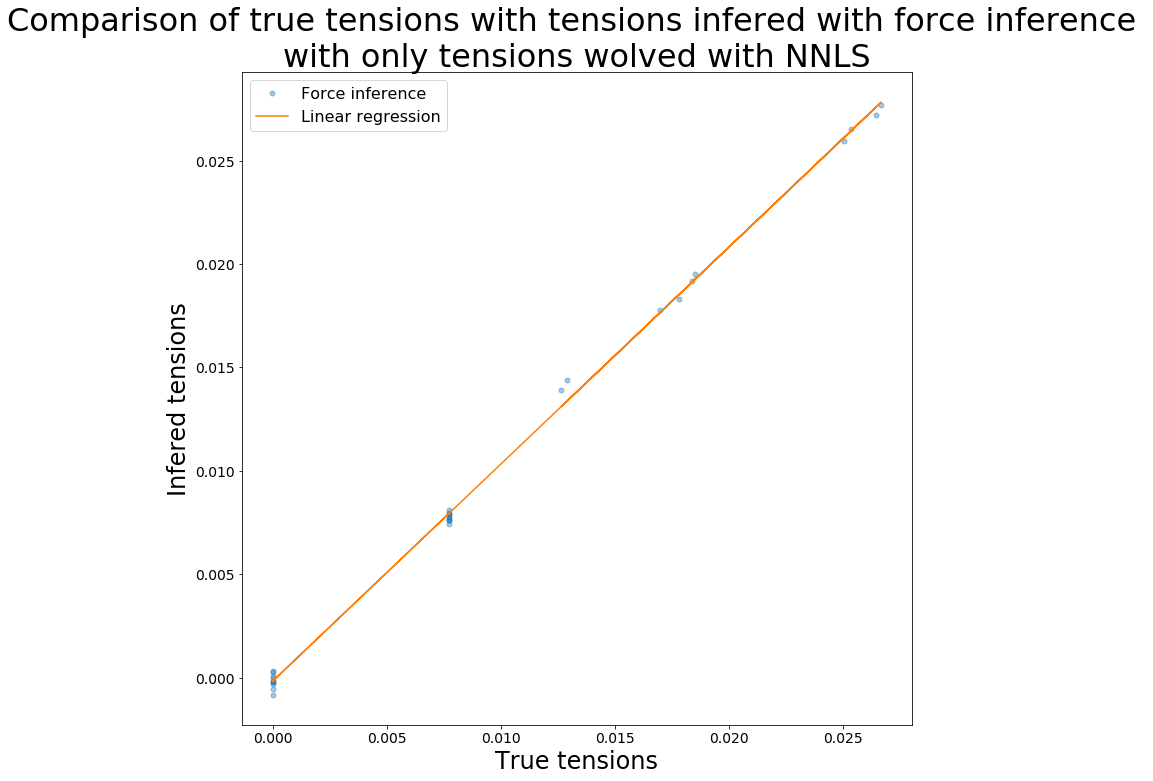

R value : 0.9992427063711065 
Standard error : 0.00031095378830322276


In [16]:
rendering_results(sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  opt_tensions_sym_organo.edge_df.line_tension[:3*sym_organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

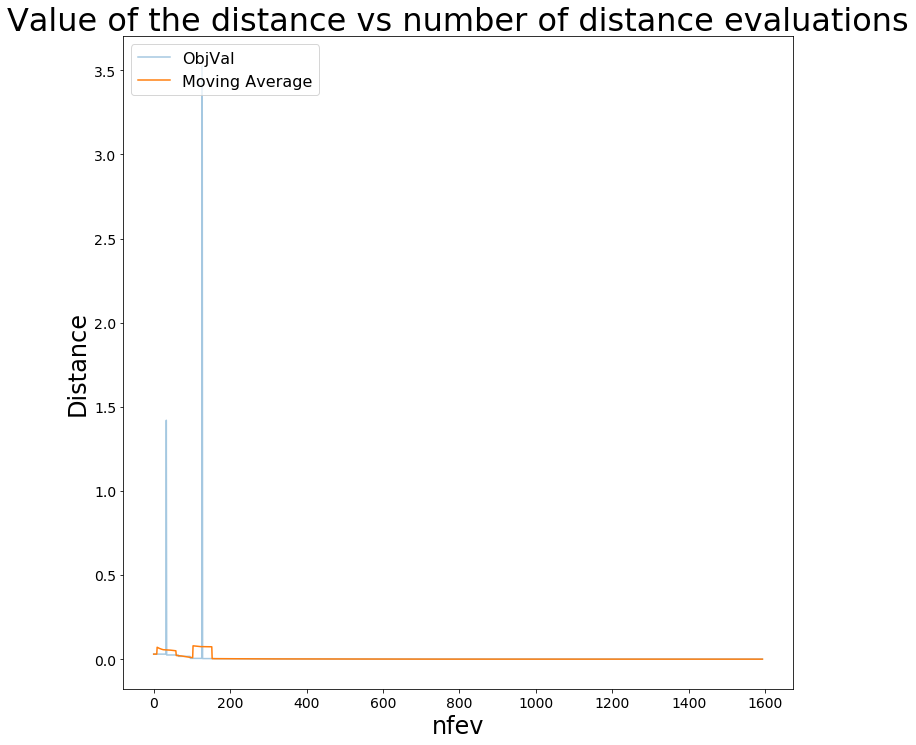

In [17]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09]), <a list of 11 Text yticklabel objects>)

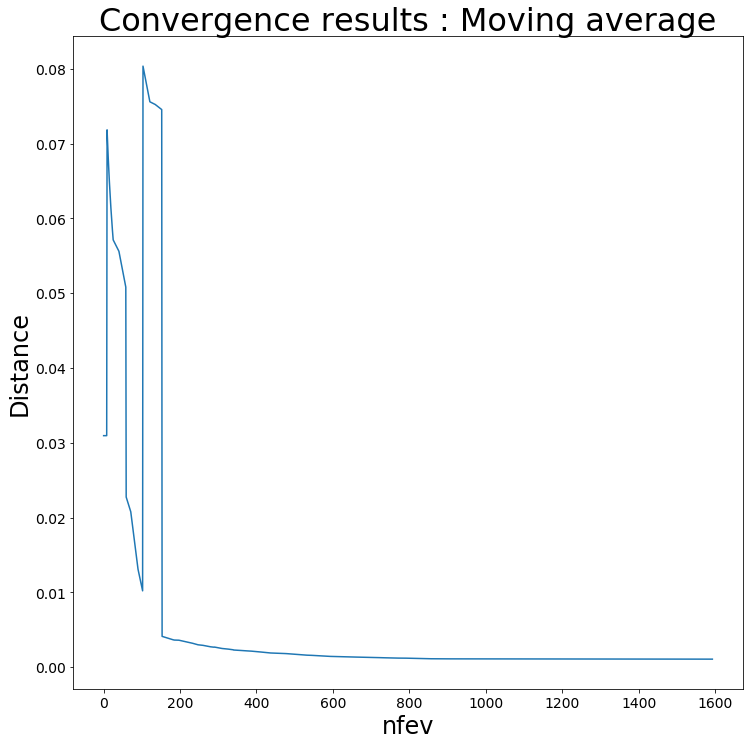

In [24]:
rolling = iter_data.rolling(50, min_periods=0, center=True).mean()
fig, ax = plt.subplots()
plt.plot(np.arange(len(iter_data[0])), rolling, '-', markersize=20, alpha=1)
plt.title("Convergence results : Moving average", fontdict={'fontsize': 32})
plt.xlabel("nfev", fontdict={'fontsize': 24})
plt.ylabel("Distance", fontdict={'fontsize': 24})
fig.set_size_inches(12, 12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)